# 네이버 영화리뷰 감성분석 도전하기

데이터 연결<br>
$ ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

### 라이브버전 확인

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

from tensorflow import keras
import tensorflow as tf
import os

### 1) 데이터 준비와 확인

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


### 2) 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [6]:
# 데이터의 중복 제거
# NaN 결측치 제거
# 한국어 토크나이저로 토큰화
# 불용어(Stopwords) 제거
# 사전word_to_index 구성
# 텍스트 스트링을 사전 인덱스 스트링으로 변환
# X_train, y_train, X_test, y_test, word_to_index 리턴

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:(index) for index, word in enumerate(vocab)}
 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '못', 105:

In [8]:
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐':

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

# RNN은 입력데이터가 순차적으로 처리되어, 가장 마지막 입력이 최종 state 값에 가장 영향을 많이 미치게 됩니다. 
# 그러므로 마지막 입력이 무의미한 padding으로 채워지는 것은 비효율적입니다. 
# 따라서 'pre'가 훨씬 유리하며, 10% 이상의 테스트 성능 차이를 보이게 됩니다.

print(X_train.shape)

(146182, 41)


## 1. RNN 모델

### 4) 모델 구성 및 validation set 구성

In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [13]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시

In [14]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # batch size 변경
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 7ms/step - loss: 0.5107 - accuracy: 0.7652 - val_loss: 0.3682 - val_accuracy: 0.8420
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3452 - accuracy: 0.8550 - val_loss: 0.3431 - val_accuracy: 0.8514
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3224 - accuracy: 0.8660 - val_loss: 0.3421 - val_accuracy: 0.8503
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3127 - accuracy: 0.8699 - val_loss: 0.3471 - val_accuracy: 0.8521
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3055 - accuracy: 0.8727 - val_loss: 0.3473 - val_accuracy: 0.8505
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3007 - accuracy: 0.8749 - val_loss: 0.3460 - val_accuracy: 0.8488
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2939 - accuracy: 0.8769 - val_loss: 0.3507 - val_accuracy: 0.8496
Epoch 

In [15]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4469 - accuracy: 0.8425
[0.44690370559692383, 0.8424842953681946]


In [16]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화

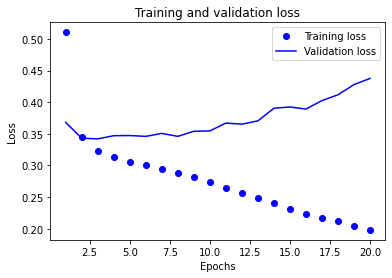

In [17]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

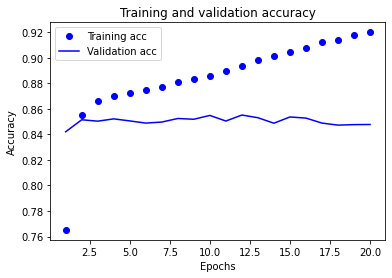

In [18]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [19]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.06529686, -0.14286627,  0.02093472,  0.05084262, -0.00268046,
       -0.0738394 ,  0.05187745,  0.01506293, -0.07642127, -0.04742375,
        0.0120457 , -0.01205688, -0.01739372,  0.17512831,  0.0349375 ,
       -0.07213154], dtype=float32)

In [22]:
word_vectors.similar_by_word("습니다")

[('달린다', 0.9455991387367249),
 ('my', 0.9384621977806091),
 ('봄', 0.9368079304695129),
 ('웨이', 0.935860276222229),
 ('어여', 0.9344574213027954),
 ('...!', 0.9335352778434753),
 ('차려', 0.9325004816055298),
 ('~~!!', 0.9298218488693237),
 ('꼇다', 0.9294183254241943),
 ('.................', 0.9294083714485168)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 

In [23]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [24]:
word_vectors.wv.most_similar("습니다")

[('어요', 0.8687134385108948),
 ('다', 0.6844717860221863),
 ('구나', 0.652129590511322),
 ('다면', 0.6467683911323547),
 ('다면서', 0.6430634260177612),
 ('으니까', 0.6382790803909302),
 ('거든요', 0.6355770230293274),
 ('느니라', 0.6240034103393555),
 ('다며', 0.6231642961502075),
 ('으니', 0.6149347424507141)]

In [25]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [26]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 3s 7ms/step - loss: 0.5654 - accuracy: 0.7084 - val_loss: 0.4359 - val_accuracy: 0.8033
Epoch 2/10
266/266 [==============================] - 1s 6ms/step - loss: 0.4035 - accuracy: 0.8215 - val_loss: 0.3749 - val_accuracy: 0.8339
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3580 - accuracy: 0.8453 - val_loss: 0.3567 - val_accuracy: 0.8441
Epoch 4/10
266/266 [==============================] - 1s 6ms/step - loss: 0.3335 - accuracy: 0.8577 - val_loss: 0.3468 - val_accuracy: 0.8466
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.3175 - accuracy: 0.8670 - val_loss: 0.3438 - val_accuracy: 0.8467
Epoch 6/10
266/266 [==============================] - 1s 6ms/step - loss: 0.3054 - accuracy: 0.8730 - val_loss: 0.3452 - val_accuracy: 0.8508
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2952 - accuracy: 0.8781 - val_loss: 0.3433 - val_accuracy: 0.8550
Epoch 

In [28]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3630 - accuracy: 0.8472
[0.36303162574768066, 0.8471835255622864]


## 2. CNN 모델

### 4) 모델 구성 및 validation set 구성

In [29]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

# model 설계
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

model = tf.keras.Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

In [30]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # batch size 변경
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 5s 15ms/step - loss: 0.4008 - accuracy: 0.8142 - val_loss: 0.3245 - val_accuracy: 0.8601
Epoch 2/10
266/266 [==============================] - 4s 14ms/step - loss: 0.2893 - accuracy: 0.8793 - val_loss: 0.3092 - val_accuracy: 0.8670
Epoch 3/10
266/266 [==============================] - 4s 14ms/step - loss: 0.2315 - accuracy: 0.9078 - val_loss: 0.3133 - val_accuracy: 0.8716
Epoch 4/10
266/266 [==============================] - 4s 14ms/step - loss: 0.1796 - accuracy: 0.9308 - val_loss: 0.3325 - val_accuracy: 0.8668
Epoch 5/10
266/266 [==============================] - 4s 14ms/step - loss: 0.1366 - accuracy: 0.9493 - val_loss: 0.3830 - val_accuracy: 0.8635
Epoch 6/10
266/266 [==============================] - 4s 14ms/step - loss: 0.1037 - accuracy: 0.9613 - val_loss: 0.4512 - val_accuracy: 0.8653
Epoch 7/10
266/266 [==============================] - 4s 14ms/step - loss: 0.0844 - accuracy: 0.9683 - val_loss: 0.4849 - val_accuracy: 0.8589

In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6443 - accuracy: 0.8538
[0.6443392634391785, 0.8538356423377991]


In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화

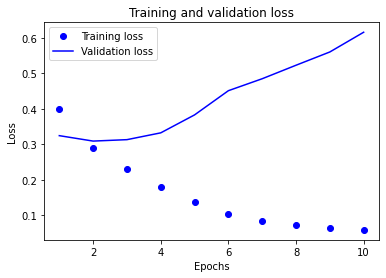

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

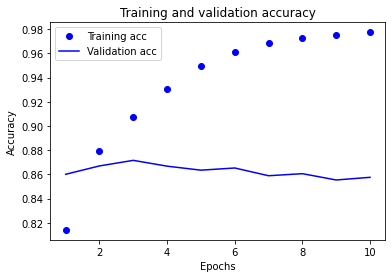

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [36]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 256)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.00753558, -0.05102534, -0.06410271, -0.01631347, -0.06381116,
       -0.04858128,  0.07275831,  0.0805527 ,  0.00553822,  0.02720868,
        0.03517481,  0.05141523, -0.01573025,  0.02186292,  0.08978655,
       -0.0344082 ,  0.04173788, -0.00607968,  0.00419997,  0.0640588 ,
        0.03595896,  0.05610633,  0.0349355 ,  0.04502871,  0.05011293,
       -0.05043202,  0.08334869,  0.04784837,  0.06703369,  0.06886323,
        0.04231089, -0.07270797, -0.00013252,  0.02375942, -0.05813476,
       -0.05669623,  0.06443687, -0.03152792,  0.03199645, -0.03356468,
       -0.04463099,  0.0044903 , -0.09330975, -0.03182633,  0.06703358,
        0.01437094, -0.03815813,  0.0013211 , -0.04398869,  0.01788628,
       -0.04031498, -0.00701648, -0.04123225,  0.01917046,  0.05944788,
       -0.01542354, -0.03358878,  0.0074737 ,  0.02221321, -0.00854347,
       -0.02509866,  0.07046305,  0.0424316 , -0.05455559,  0.02171289,
       -0.00119878,  0.02281149, -0.02636282,  0.0698456 , -0.03

In [39]:
word_vectors.similar_by_word("습니다")

[('네요', 0.32240065932273865),
 ('모른', 0.3195347189903259),
 ('놨다', 0.31746381521224976),
 ('외계인', 0.30775660276412964),
 ('불렀', 0.29755744338035583),
 ('사이코패스', 0.29752808809280396),
 ('음', 0.28392472863197327),
 ('유령', 0.28017494082450867),
 ('예전', 0.2726278305053711),
 ('줄께', 0.27001458406448364)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [40]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense

# model 설계
embedding_dim = 100 # 임베딩 벡터의 차원
dropout_ratio = 0.3 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 256)           77056     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [41]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 10ms/step - loss: 0.6529 - accuracy: 0.6664 - val_loss: 0.5029 - val_accuracy: 0.7575
Epoch 2/20
266/266 [==============================] - 2s 9ms/step - loss: 0.5098 - accuracy: 0.7494 - val_loss: 0.4394 - val_accuracy: 0.7973
Epoch 3/20
266/266 [==============================] - 2s 9ms/step - loss: 0.4574 - accuracy: 0.7842 - val_loss: 0.3999 - val_accuracy: 0.8175
Epoch 4/20
266/266 [==============================] - 2s 9ms/step - loss: 0.4172 - accuracy: 0.8089 - val_loss: 0.3651 - val_accuracy: 0.8356
Epoch 5/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3909 - accuracy: 0.8229 - val_loss: 0.3554 - val_accuracy: 0.8404
Epoch 6/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3725 - accuracy: 0.8332 - val_loss: 0.3378 - val_accuracy: 0.8450
Epoch 7/20
266/266 [==============================] - 2s 9ms/step - loss: 0.3581 - accuracy: 0.8415 - val_loss: 0.3283 - val_accuracy: 0.8548
Epoch

In [42]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3223 - accuracy: 0.8635
[0.32228121161460876, 0.8634782433509827]


## 3. GlobalMaxPooling1D 모델

### 4) 모델 구성 및 validation set 구성

In [43]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,562,065
Trainable params: 2,562,065
Non-trainable params: 0
_________________________________________________________________


In [44]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### 5) 모델 훈련 개시

In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.4507 - accuracy: 0.8112 - val_loss: 0.3387 - val_accuracy: 0.8533
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3067 - accuracy: 0.8705 - val_loss: 0.3268 - val_accuracy: 0.8562
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2608 - accuracy: 0.8940 - val_loss: 0.3314 - val_accuracy: 0.8569
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2188 - accuracy: 0.9152 - val_loss: 0.3476 - val_accuracy: 0.8535
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1750 - accuracy: 0.9361 - val_loss: 0.3690 - val_accuracy: 0.8520
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1302 - accuracy: 0.9564 - val_loss: 0.4070 - val_accuracy: 0.8513
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.0900 - accuracy: 0.9736 - val_loss: 0.4546 - val_accuracy: 0.8434
Epoch 

In [46]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5971 - accuracy: 0.8419
[0.5970693230628967, 0.8418740034103394]


In [47]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화

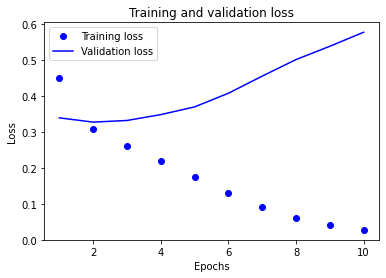

In [48]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

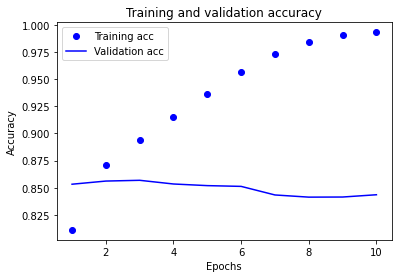

In [49]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7) 학습된 Embedding 레이어 분석

In [50]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 256)


In [51]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [52]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 3.75274792e-02, -4.97958157e-03, -1.27620578e-01, -1.32087246e-01,
       -1.87962592e-01, -1.69779062e-01, -1.64700393e-02, -1.08851559e-01,
       -9.45437029e-02, -8.99755135e-02, -1.15084112e-01, -1.27940357e-01,
       -1.34778261e-01, -1.77753083e-02, -1.06040962e-01, -1.32260785e-01,
       -1.45597249e-01, -1.33411378e-01, -1.02592073e-01,  1.18187340e-02,
       -1.11593179e-01, -7.48026222e-02, -1.15417175e-01, -8.47317353e-02,
       -1.46251619e-01, -1.20728441e-01, -1.77437533e-02, -9.90338847e-02,
       -6.17223941e-02, -1.44941822e-01, -1.04098417e-01, -1.09567761e-01,
        3.75087820e-02, -7.36896992e-02, -9.52316150e-02, -1.47032723e-01,
       -6.85320869e-02, -7.94174522e-02, -1.04336031e-01, -5.35360649e-02,
       -8.21801499e-02, -1.19649656e-01, -6.35306612e-02, -1.20376490e-01,
       -1.06159747e-01, -9.54964831e-02, -9.81602147e-02, -1.37254581e-01,
       -1.33303106e-01, -1.11846566e-01, -4.23152931e-02, -1.36538312e-01,
       -1.25747502e-01, -

In [53]:
word_vectors.similar_by_word("습니다")

[('보', 0.4480113089084625),
 ('.', 0.4462924897670746),
 ('묘사', 0.4433269500732422),
 ('영화', 0.43189144134521484),
 ('너무', 0.42968064546585083),
 ('~~', 0.4274543523788452),
 ('을', 0.4234645962715149),
 ('는다', 0.42312654852867126),
 ('하', 0.4226166903972626),
 ('까지', 0.42047494649887085)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [54]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


In [57]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3569 - accuracy: 0.8436 - val_loss: 0.4120 - val_accuracy: 0.8115
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3521 - accuracy: 0.8463 - val_loss: 0.4117 - val_accuracy: 0.8133
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3487 - accuracy: 0.8483 - val_loss: 0.4114 - val_accuracy: 0.8156
Epoch 4/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3437 - accuracy: 0.8512 - val_loss: 0.4111 - val_accuracy: 0.8170
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.3394 - accuracy: 0.8532 - val_loss: 0.4081 - val_accuracy: 0.8152
Epoch 6/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3357 - accuracy: 0.8553 - val_loss: 0.4092 - val_accuracy: 0.8170
Epoch 7/20
266/266 [==============================] - 1s 3ms/step - loss: 0.3315 - accuracy: 0.8572 - val_loss: 0.4163 - val_accuracy: 0.8111
Epoch 

In [58]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4353 - accuracy: 0.8170
[0.43525996804237366, 0.8169741630554199]


<회고><br>

Accuracy 결과<br>
- RNN 모델: 0.8425 > 0.8472
- CNN 모델: 0.8538 > 0.8635
- GlobalMaxPooling1D 모델: 0.8419 > 0.8170
- CNN 모델을 사용한 것이 word2vec까지 사용한 최종 결과가 0.8635로 가장 accuracy가 높았다

어려웠던 점<br>
- 이번 노드는 데이터 로더부터 모델 찾기, 한국어 word2vec 임베딩 적용까지 어느 하나 쉬운 게 없었던 것 같다.
- 직접 검색을 해서 찾아야 하는 것들이 많았고, 검색을 해서 예시를 찾아도 실제 코드로 적용하는 것이 어려웠다.

더 알아보면 좋을 것<br>
- word2vec을 사용하면 일반적으로 성능이 더 좋아진다고 알고 있는데, GlobalMaxPooling1D 모델을 사용한 것은 오히려 정확도가 떨어졌다. 왜?